# Een eerste neuraal netwerk

In deze notebook wordt getoond hoe een neuraal netwerk opgebouwd kan worden met Pytorch.
Hierbij wordt er dieper ingegaan op de keuzes van hyperparameters.

In de eerste codecell importeren we de nodige functionaliteiten van pytorch. 
Daarna maken we ook een aantal variabelen aan die we gaan gebruiken voor het aanmaken van het netwerk.
De betekenis van deze parameters is:
* input_size: aantal features in de dataset
* hidden_size: aantal neuronen in de enkele hidden laag
* output_size: aantal neuronen in de outputlaag
* learning_rate: de learning rate van de optimizer
* epochs: aantal keer dat de volledige dataset gebruikt wordt voor training
* batch_size: hoeveel inputs er gegroepeerd worden voordat de gewichten geoptimaliseerd worden
* dropout_rate: het aantal connecties dat op een willekeurige manier zal wegvallen

Voor de input_size heb je meestal geen keuze. Deze wordt bepaald door de gegeven dataset. Elke feature van de input wordt namelijk gematchet op een neuron in de inputlayer.
Ook de output_size wordt bepaald door het probleem. Dit is de gewenste output dus:
* Bij een regressieprobleem is er 1 neuron per ter voorspellen waarde
* Bij classificatie is er 1 neuron per klasse
    * In het geval van 2 klassen kan je gebruik maken van 1 klasse

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Configuratie
input_size = 20       # Aantal ingangsfeatures
hidden_size = 64      # Grootte van de verborgen lagen
output_size = 2       # Aantal klassen (voor classificatie)
learning_rate = 0.001 # Learning rate
epochs = 50           # Aantal epochs
batch_size = 32       # Batch grootte
dropout_rate = 0.5    # Dropout rate voor regularisatie

Na het bepalen van de configuratie kan de dataset gemaakt worden. Dit gebeurd met de make_classification functie van scikit-learn om met random data te werken.
In dit voorbeeld is er gekozen voor een classificatieprobleem met 2 klassen.

Deze dataset wordt daarna gesplits in features en labels, en gepslitst in trainings- en testdata.
In pytorch ziet dit eruit als volgt

In [2]:
# Dataset maken
X, y = make_classification(n_samples=1000, n_features=input_size, n_classes=output_size, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DataLoader maken
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # deze op False want heeft geen nut -> test-data is slechts 1 epoch

Indien er niet gebruik gemaakt wordt van pytorch maar van tensorflow, dan bekom je de volgende code

In [3]:
import tensorflow as tf

# DataLoader maken
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

2024-10-04 12:52:07.859696: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 12:52:07.997715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 12:52:08.040082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 12:52:08.054831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 12:52:08.128452: I tensorflow/core/platform/cpu_feature_guar

## Klasieke techniek om NN op te stellen met pytorch
Hierna kan het neuraal netwerk aangemaakt worden.
Eerst gaan we werken met de klassieke en meest manuele manier.
Dit gaat misschien niet de meest beknopte manier zijn maar geeft je wel de meeste mogelijkheden om het model en trainingsproces aan te passen aan je noden.

De klassieke techniek met pytorch is om een klasse te maken die overerft van de Module-klasse.
In deze klasse moet je de volgende zaken aanpassen:

* In de constructor van deze klasse maak je de nodige lagen aan van het neuraal netwerk.
* In de forward functie van de klasse geef je dan hoe deze lagen aan elkaar gekoppeld worden.

In onderstaande voorbeeld worden vier eenvoudige lagen aangemaakt (1 voor de inputs, 2 voor de hiden layers en 1 voor de output layer). De activatiefunctie wordt toegevoegd in de forward functie. In het model hieronder is er gekozen om te werken met een Relu-functie na de input en hidden layer. De output layer bevat een standaard lienaire functie. Dit omdat pytorch beschikt over een speciale loss-functie om een sigmoid/softmax in de output layer overbodig te maken wat efficienter is.

In [4]:
# Neuraal Netwerk Model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x) # bij pytorch met cross entropy moet hier geen softmax activatiefunctie staan
        return x
        
# Model, verliesfunctie en optimizer
model = NeuralNet(input_size, hidden_size, output_size, dropout_rate)

Om dit model te trainen moet er eerst bepaald worden wat er moet geoptimaliseerd worden.
Dit is **de loss-functie** die moet geminimaliseerd worden.
Dit wordt ook bepaald door het op te lossen probleem, namelijk:

* Bij regressie wordt er typisch gekozen voor Mean-Squared-Error (noemt in pytorch MSELoss) of Mean-Squared-Error
* Bij classificatie wordt er gekozen voor
    * BCEWithLogitsLoss bij binaire classificatie (BCE staat voor Binary Cross Entropy )
        * Hierbij moet geen sigmoid activatiefunctie gebruikt worden want dit is reeds ingebouwd in de loss-functie
        * Indien er toch een sigmoid-functie gebruikt wordt in de output-layer: BCELoss
    * CrossEntropy in het geval van multi-class classification (meerdere opties maar slechts 1 klasse te kiezen)
    * BCEWithLogitsLoss bij multilabel classificatie
        *  Aangezien elk outputneuron een binaire classificatie is
     
Daarna wordt de training uitgevoerd door het aantal epoch keer de dataset te gebruiken om de gewichten te optimaliseren.
Hiervoor moet er per epoch het volgende uitgevoerd worden:
* Zet het model in een trainingsmodus
* Geef de data aan het model en doe per batch
    * Bereken de outputs
    * Bereken de error tussen de outputs en gewenste labels
    * Voer backwards propagation uit om gewichten up te daten
* Zet het model in een evaluatie modus
* Bereken de totale loss op de test-date
    *  Dit wordt gebruikt om de prestaties van het model op te volgen en kan gebruikt worden om het trainen eerder te stoppen indien er overfitting gedetecteerd wordt.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
test_losses = []

# loop een aantal keer over de dataset
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    # ga door de hele train data
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        # bereken de output met het huidige netwerk
        outputs = model(inputs)
        # bereken de error
        loss = criterion(outputs, labels)
        # pas de gewichten aan volgens de fout
        loss.backward()
        # pas de learning rate aan
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))

    # gaan testen -> belangrijkste verschil is dat je hier no_grad gebruikt en geen loss.backward()
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    test_losses.append(test_loss / len(test_loader))
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

Epoch 1/50, Train Loss: 0.6616, Test Loss: 0.6077
Epoch 2/50, Train Loss: 0.5703, Test Loss: 0.5099
Epoch 3/50, Train Loss: 0.4984, Test Loss: 0.4210
Epoch 4/50, Train Loss: 0.4179, Test Loss: 0.3728
Epoch 5/50, Train Loss: 0.3736, Test Loss: 0.3540
Epoch 6/50, Train Loss: 0.3924, Test Loss: 0.3422
Epoch 7/50, Train Loss: 0.3501, Test Loss: 0.3359
Epoch 8/50, Train Loss: 0.3655, Test Loss: 0.3327
Epoch 9/50, Train Loss: 0.3568, Test Loss: 0.3323
Epoch 10/50, Train Loss: 0.3510, Test Loss: 0.3298
Epoch 11/50, Train Loss: 0.3274, Test Loss: 0.3327
Epoch 12/50, Train Loss: 0.3200, Test Loss: 0.3291
Epoch 13/50, Train Loss: 0.3157, Test Loss: 0.3303
Epoch 14/50, Train Loss: 0.3208, Test Loss: 0.3301
Epoch 15/50, Train Loss: 0.2894, Test Loss: 0.3360
Epoch 16/50, Train Loss: 0.3348, Test Loss: 0.3336
Epoch 17/50, Train Loss: 0.3122, Test Loss: 0.3398
Epoch 18/50, Train Loss: 0.2844, Test Loss: 0.3392
Epoch 19/50, Train Loss: 0.2978, Test Loss: 0.3413
Epoch 20/50, Train Loss: 0.2874, Test Lo

De resultaten van het trainingsproces kunnen geplot worden met onderstaande code
De x-as stelt de prestaties van het model voor doorheen het trainingsproces.
Het resulteren model heeft dus de prestaties in de laatste epoch.
Deze figuur kan gebruikt worden om
* De stabiliteit van het model te valideren
    * Een onstabiel model (met veel variatie in de output zal niet goed generaliseren)
* Het aantal gekozen epochs/learning rate te valideren
    * Als de loss-functie nog snel daalt moet het aantal epochs of de learning rate verhoogd worden
* Underfitting detecteren
    * Als de error nog te hoog is voor je doelstelling is ofwel het model niet complex genoeg of de data niet goed genoeg 
* Overfitting detecteren
    * Als er een punt is waarop de test-loss (error op de testdata) terug toeneemt en de train-loss verder daalt. Dan treedt er vanaf die epoch overfitting op
    * Dit kan vermeden worden door meer regularisatie toe te voegen of de complexiteit van het model te verlagen
    * Het aantal epochs reduceren tot dit punt is niet goed want dan verlaag je de prestaties van je model.

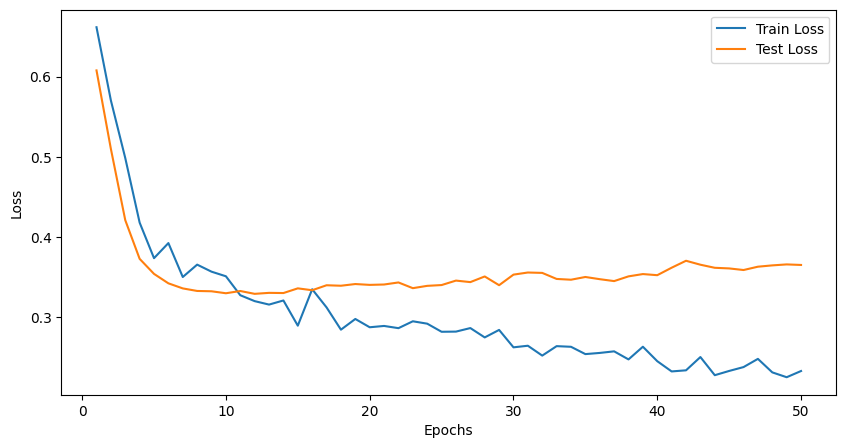

Accuracy of the model on the test set: 86.00%


In [6]:
# Resultaten plotten
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model evaluatie
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')

# hier treed overfitting op
# oplossen: meer dropout (is hier reeds aanwezig), early stopping, eenvoudig model (minder neuronen/minder lagen)

## Kortere maar minder flexibele schrijfwijze

Aangezien bovenstaande model een standaard structuur heeft kan het ook herschreven worden als een functioneel model.
In dit geval ziet de code eruit als volgt

In [8]:
# Model opbouwen met nn.Sequential
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_size, output_size)
)

Hierbij is de opbouw van het model vereenvoudigd maar de traningslus moet nog steeds voluit geschreven worden.

## Model opbouwen met trainen

Een derde manier om de code te schrijven is door middel van **Keras**. 
Deze manier van code schrijven is identiek aan hoe het eruitziet inden er gebruik gemaakt wordt van **Tensorflow**.
Met keras kan zowel de opbouw van het model als de trainingslus sterk vereenvoudigd worden.

Merk op dat hieronder **wel een softmax nodig is** omdat de standaard crossentropy functies van keras/tensorflow dit vereisen. 
Daarnaast is het ook interessant dat Keras een summary kan uitprinten van een model om een overzicht te krijgen van de architectuur en het aantal parameters dat in elke laag moet getrained worden.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,634 (22.01 KB)

 Trainable params: 5,634 (22.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5196 - loss: 0.7450 - val_accuracy: 0.7050 - val_loss: 0.5823
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6491 - loss: 0.6653 - val_accuracy: 0.7700 - val_loss: 0.5189
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6973 - loss: 0.5962 - val_accuracy: 0.7950 - val_loss: 0.4793
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7513 - loss: 0.5376 - val_accuracy: 0.8050 - val_loss: 0.4437
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7936 - loss: 0.4488 - val_accuracy: 0.8150 - val_loss: 0.4194
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8001 - loss: 0.4293 - val_accuracy: 0.8300 - val_loss: 0.4053
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8199 - loss: 0.4257 - val_accuracy: 0.8350 - val_loss: 0.3926
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8148 - loss: 0.4090 - val_accuracy: 0.8300 - val_loss:

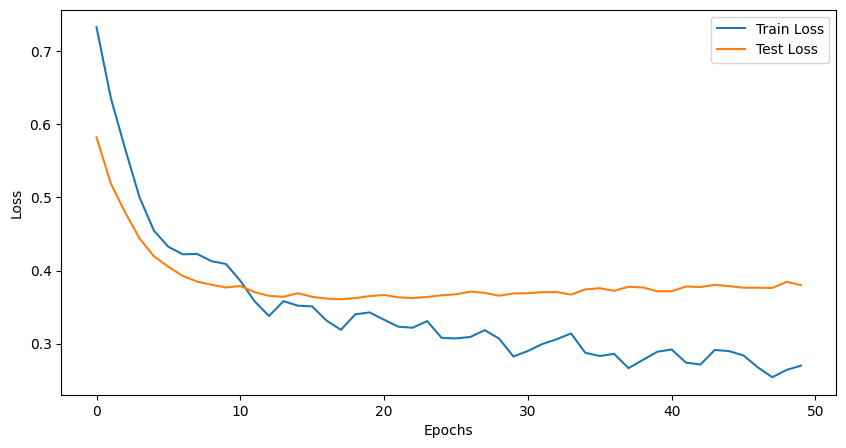

Accuracy of the model on the test set: 84.50%


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Model opbouwen met Keras Sequential API
model = Sequential()
model.add(Dense(hidden_size, activation='relu', input_shape=(input_size,)))
model.add(Dropout(dropout_rate))
model.add(Dense(hidden_size, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(output_size, activation='softmax'))

# Model compileren
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model samenvatting tonen
model.summary()

# Model trainen
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    verbose=1)

# Resultaten plotten
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluatie op de test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy of the model on the test set: {accuracy*100:.2f}%')

## Oefening 1: Binaire classificatie

Train een feed-forward neurale netwerk voor binaire classificatie met behulp van de make_classification functie van sklearn om een dataset te genereren.

Gebruik een eenvoudig netwerk met één verborgen laag van 64 neuronen en een sigmoid activatiefunctie.
Schrijf je code aan de hand van Keras

**Uitbreiding (ook voor alle andere oefeningen)** Oefen ook de andere code-schrijfwijzen

In [ ]:
# Dataset genereren
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Data splitsen in train en test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model opbouwen
model = Sequential([
    Dense(64, activation='relu', input_shape=(20,)),
    Dense(1, activation='sigmoid')
])

# Model compileren
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model trainen
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Resultaten plotten
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluatie op de test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy of the model on the test set: {accuracy*100:.2f}%')


## Oefening 2: Multiklasse classificatie met Iris Dataset

Train een feed-forward neurale netwerk voor multiklasse classificatie met behulp van de load_iris functie van sklearn om de Iris dataset te laden.
Gebruik een netwerk met drie verborgen laag van 32 neuronen en een softmax activatiefunctie.

Schrijf je code aan de hand van nn.Sequential (tweede schrijfwijze)

In [ ]:
from sklearn.datasets import load_iris

# Dataset laden
iris = load_iris()
X, y = iris.data, iris.target

# Data splitsen in train en test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert naar PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataset en DataLoader maken
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model definieren met nn.Sequential
model = nn.Sequential(
    nn.Linear(4, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 3)  # 3 output klassen voor Iris dataset
)

# Loss functie en optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Oefening 3: Regressie met Diabetes Dataset

Train een feed-forward neurale netwerk voor regressie met behulp van de load_diabetes functie van sklearn om de Diabetes dataset te laden.
Gebruik een netwerk met één verborgen laag van 64 neuronen en een gepaste activatiefunctie

Gebruik voor deze oefeningen de klassieke pytorch schrijfwijze

In [ ]:
from sklearn.datasets import load_diabetes

# Dataset laden
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# Data splitsen in train en test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converteren naar PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Unsqueezing om dimensie te matchen
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Dataset en DataLoader maken
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Definitie van het neurale netwerk met nn.Module
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(10, 64)   # 10 input features naar 64 hidden units
        self.fc2 = nn.Linear(64, 1)    # 64 hidden units naar 1 output (lineaire activatie)

    def forward(self, x):
        x = torch.relu(self.fc1(x))   # ReLU activatie in de hidden layer
        x = self.fc2(x)               # Lineaire activatie in de output layer
        return x

# Model initialiseren
model = NeuralNet()

# Loss functie en optimizer
criterion = nn.MSELoss()

## Oefening 4: Binaire classificatie met Moons Dataset

Train een feed-forward neurale netwerk voor binaire classificatie met behulp van de make_moons functie van sklearn om een maanvormige dataset te genereren.
Pas in deze oefening l2-regularisatie toe ipv dropout.

Gebruik de keras notatie met een pytorch backend (code hiervoor al gegeven hieronder)

In [ ]:
import os

# This guide can only be run with the torch backend.
os.environ["KERAS_BACKEND"] = "torch"

from sklearn.datasets import make_moons
from keras.regularizers import l2

# Dataset genereren
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Data splitsen in train en test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model opbouwen
model = Sequential([
    Dense(32, activation='relu', kernel_regularizer=l2(0.01), input_shape=(2,)),
    Dense(1, activation='sigmoid')
])

# Model compileren
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model trainen
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

## Oefening 5: Multilabel classificatie met Circles Dataset

Train een feed-forward neurale netwerk voor multilabel classificatie met behulp van de make_circles functie van sklearn om een dataset met cirkelvormige klassen te genereren.

Maak gebruik van nn.Module inheritance om dit model te schrijven en zorg voor regularisation door gebruik te maken van de L2-norm.

In [ ]:
from sklearn.datasets import make_circles

# Dataset genereren
X, y = make_circles(n_samples=1000, noise=0.1, random_state=42)

# Omzetten naar PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Data splitsen in train en test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definitie van het neurale netwerk met nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input layer naar hidden layer
        self.fc2 = nn.Linear(64, 1)  # Hidden layer naar output layer
        self.relu = nn.ReLU()        # ReLU activatie voor hidden layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Model instantiëren
model = Net()

# Loss functie (Binary Cross Entropy) en optimizer (Adam)
criterion = nn.BCEWithLogitsLoss()